<a href="https://colab.research.google.com/github/KndHvH/study/blob/2/T2_MATIAS_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho #2 - Rede residual e ajuste de modelo

Nesse trabalho você vai criar uma rede residual para realizar uma tarefa de classificação de múltiplas classes.

A tarefa consiste em classificar objetos do conjunto de dados CIFAR100

Esse trabalho é dividido nas seguintes etapas:

1. Explorar as imagens do conjunto de dados;
2. Construir e treinar uma rede residual para identificar o objeto mostrado na imagem;
3. Avaliar o desempenho da rede;
4. Ajustar o modelo para melhorar o desempenho.

### Importação das principais bibliotecas

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import os
import kagglehub
from PIL import Image
tf.__version__

'2.17.1'

## 1. Conjunto de dados

O conjunto de dados Brain tumors é composto por imagens de dimensão (256, 256 , 1).

Esse conjunto de imagens é dedicado à classificçaõ multiclasse com 4 tipos de objetos.


In [ ]:
dataset_path = kagglehub.dataset_download("thomasdubail/brain-tumors-256x256")

print("Path to dataset files:", dataset_path)

100%|██████████| 59.4M/59.4M [00:04<00:00, 14.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1


In [ ]:
dataset_path = os.path.join(dataset_path, 'Data')

In [ ]:
print("Arquivos no dataset:")
print(os.listdir(dataset_path))

Arquivos no dataset:
['pituitary_tumor', 'glioma_tumor', 'normal', 'meningioma_tumor']


In [ ]:
for root, dirs, files in os.walk(dataset_path):
    print(f"Diretório: {root}")
    print(f"Subdiretórios: {dirs}")
    print(f"Arquivos: {files[:5]}")
    print("-" * 50)

Diretório: /root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1/Data
Subdiretórios: ['pituitary_tumor', 'glioma_tumor', 'normal', 'meningioma_tumor']
Arquivos: []
--------------------------------------------------
Diretório: /root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1/Data/pituitary_tumor
Subdiretórios: []
Arquivos: ['P_644.jpg', 'P_331.jpg', 'P_516.jpg', 'P_608.jpg', 'P_31.jpg']
--------------------------------------------------
Diretório: /root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1/Data/glioma_tumor
Subdiretórios: []
Arquivos: ['G_353.jpg', 'G_46.jpg', 'G_422.jpg', 'G_438.jpg', 'G_350.jpg']
--------------------------------------------------
Diretório: /root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1/Data/normal
Subdiretórios: []
Arquivos: ['N_78.jpg', 'N_298.jpg', 'N_55.jpg', 'N_148.jpg', 'N_189.jpg']
--------------------------------------------------
Diretório: /root

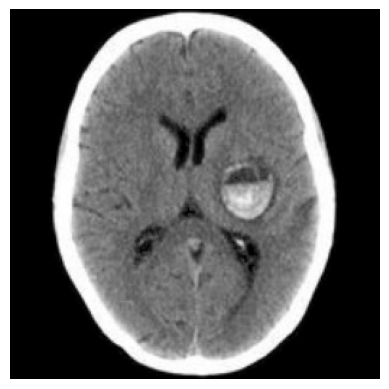

In [ ]:
sample_image_path = os.path.join(dataset_path, 'glioma_tumor', 'G_301.jpg')

image = Image.open(sample_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

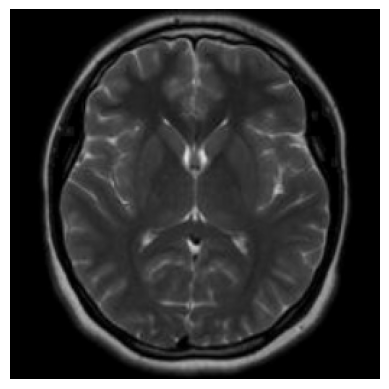

In [ ]:
sample_image_path = os.path.join(dataset_path, 'normal', 'N_282.jpg')

image = Image.open(sample_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
image_size = (256, 256)
image = Image.open(sample_image_path).convert('L').resize(image_size)
image_array = np.array(image).flatten()

data = [image_array]
labels = ['normal']

df = tf.data.Dataset.from_tensor_slices((data, labels))


In [ ]:
list(df)[0][0][20000].numpy()

[(<tf.Tensor: shape=(65536,), dtype=uint8, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)>,
  <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>)]

### Exercício #1: Pré-processamento dos dados

Na célula abaixo crie um código para realizar o seguinte:

1. Normalizar as imagens de forma que os seus pixels sejam valores reais entre 0 e 1;

2. Codificação one-hot das saídas.

In [ ]:
classes = ['normal', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor']

data = []
labels = []

image_size = (128, 128)
batch_size = 10
n_augmentation = 5


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
def process_in_batches(dataset_path, classes, batch_size, image_size, n_aug):
    augmented_data = []
    augmented_label = []
    og_img = 1
    for label in classes:
        class_path = os.path.join(dataset_path, label)
        image_files = os.listdir(class_path)

        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
            batch_data = []
            batch_label = []

            for image_file in batch_files:
                if og_img % 100 == 0: print('N:',og_img)
                og_img += 1

                image_path = os.path.join(class_path, image_file)

                # Carregar a imagem original, redimensionar e converter para escala de cinza
                image = Image.open(image_path).convert('L').resize(image_size)
                image_array = np.array(image).reshape((1,) + image_size + (1,))  # Para o datagen

                # Adicionar a imagem original ao batch
                original_flattened = image_array.flatten()  # Achatar a imagem
                # batch_data.append(np.append(original_flattened, label))  # Adicionar ao batch_data
                batch_data.append(original_flattened)
                batch_label.append(label)

                # Gerar imagens augmentadas
                augmented_count = 0
                for augmented_batch in datagen.flow(image_array, batch_size=1):
                    augmented_image = augmented_batch[0].astype('float32')  # Imagem augmentada
                    augmented_flattened = augmented_image.flatten()  # Achatar a imagem

                    # batch_data.append(np.append(augmented_flattened, label))  # Adicionar ao batch_data
                    batch_data.append(augmented_flattened)
                    batch_label.append(label)

                    augmented_count += 1
                    if augmented_count >= n_aug:  # Gerar no máximo n_aug augmentações
                        break

            augmented_data.extend(batch_data)
            augmented_label.extend(batch_label)

    return augmented_data, augmented_label



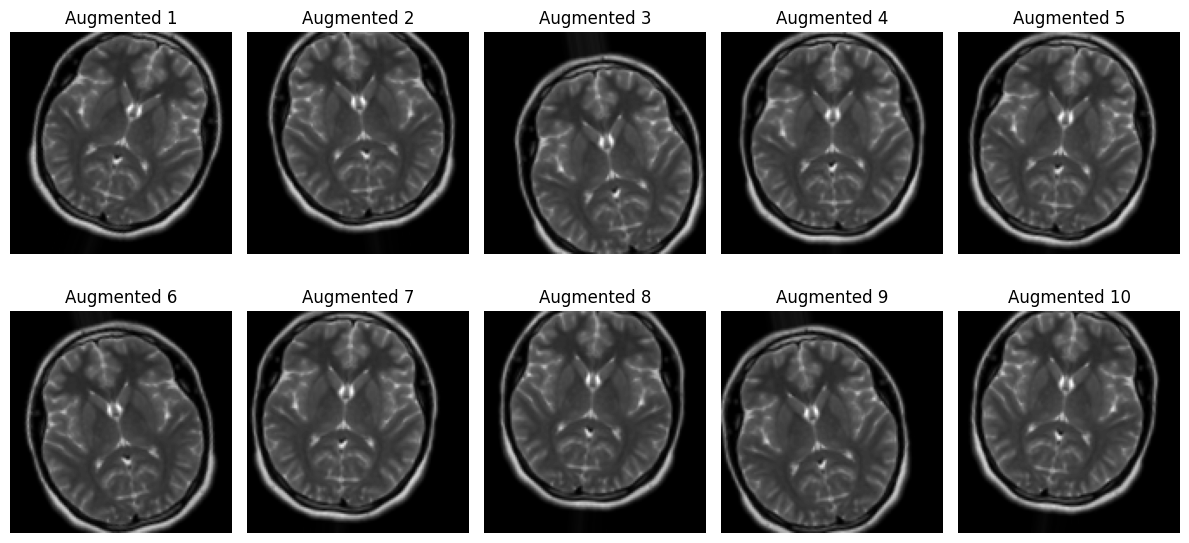

In [ ]:
# Carregar a imagem, redimensionar e converter para escala de cinza
image = Image.open(sample_image_path).convert('L').resize(image_size)
image_array = np.array(image).reshape((1,) + image_size + (1,))  # Formato necessário para o datagen

# Gerar imagens augmentadas e plotar
plt.figure(figsize=(12, 6))  # Tamanho do grid de plots
for i, augmented_batch in enumerate(datagen.flow(image_array, batch_size=1)):
    augmented_image = augmented_batch[0].reshape(image_size)  # Remover batch dimension para plotar

    # Plotar a imagem augmentada
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Augmented {i+1}")

    if i == 9:  # Gerar apenas 10 augmentações
        break

plt.tight_layout()
plt.show()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(process_in_batches(dataset_path, classes, batch_size, image_size,n_augmentation))

N: 100
N: 200
N: 300
N: 400
N: 500
N: 600
N: 700
N: 800
N: 900
N: 1000
N: 1100
N: 1200
N: 1300
N: 1400
N: 1500
N: 1600
N: 1700
N: 1800
N: 1900
N: 2000
N: 2100
N: 2200
N: 2300
N: 2400
N: 2500
N: 2600
N: 2700
N: 2800
N: 2900
N: 3000


In [ ]:
# columns = [f"pixel_{i}" for i in range(image_size[0] * image_size[1])] + ['label']
# df = pd.DataFrame(data, columns=columns)
for image_batch, label_batch in dataset.take(1):
    print("Image shape:", image_batch.shape)
    print("Label:", label_batch.numpy())
    print("Tipo das imagens:", image_batch.dtype)
    print("Tipo dos rótulos:", label_batch.dtype)
    print("Valor do Pixel 10000:", image_batch[10000].numpy())


Image shape: (16384,)
Label: b'normal'
Tipo das imagens: <dtype: 'float32'>
Tipo dos rótulos: <dtype: 'string'>
Valor do Pixel 10000: 115.0


In [ ]:
# Normalizacao para 0-1
# df.iloc[:, :-1] = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
# df.iloc[:, :-1] = df.iloc[:, :-1] / 255.0

def normalize(image, label):
    image = image / 255.0
    return image, label

normalized_dataset = dataset.map(normalize)

In [ ]:
pixels = []
labels = []

for image_batch, label_batch in normalized_dataset:
    pixels.append(image_batch)
    labels.append(label_batch)

In [ ]:
print(pixels[0][10000])

tf.Tensor(0.4509804, shape=(), dtype=float32)


In [ ]:
print('Valores máximos e mínimos dos pixels:', np.max(pixels), ',', np.min(pixels))

Valores máximos e mínimos das image: 1.0 , 0.0


In [ ]:
# Aplicar PCA sem reduzir componentes inicialmente
pca = PCA()
pca.fit(pixels)  # pixels são os valores normalizados

# Calcular a variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
# Plotar a curva
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='.')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Curva de Variância Explicada')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=2000)
pixels_pca = pca.fit_transform(pixels)

reconstructed_pixels = pca.inverse_transform(pixels_pca)

In [ ]:
class_path = os.path.join(dataset_path, 'normal')
image_files = os.listdir(class_path)
image_files[0]

In [ ]:
reconstructed_image = reconstructed_pixels[0].reshape(256, 256)

# Plotar a imagem original e a reconstruída
sample_image_path = os.path.join(dataset_path, 'normal', 'N_173.jpg')
original_image = Image.open(sample_image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagem Original")

plt.imshow(original_image)
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title("Imagem Reconstruída")
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar para o intervalo [0, 1]
scaler = MinMaxScaler()
pca_normalized = scaler.fit_transform(pixels_pca)

In [ ]:
pca_normalized.shape

In [ ]:
labels.shape

In [ ]:
one_hot_labels = pd.get_dummies(labels, dtype=int)
one_hot_labels.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_normalized, one_hot_labels, test_size=0.2, random_state=42)

In [ ]:
# PASRA VOCÊ FAZER: Normalização das imagens e codificação one-hot das saídas
# Importa função to_categorical


print(f"Dimensão do conjunto de treinamento: {X_train.shape}")
print(f"Dimensão do conjunto de teste: {X_test.shape}")
print(f"Dimensão das saídas de treinamento: {y_train.shape}")
print(f"Dimensão das saídas de teste: {y_test.shape}")
print('Valores máximos e mínimos das imagens de treinamento:', np.max(X_train), ',', np.min(X_train))
print('Valores máximos e mínimos das imagens de teste:', np.max(X_test), ',',  np.min(X_test))

**Saída esperada:**

    Dimensão do conjunto de treinamento: (50000, 32, 32, 3)
    Dimensão do conjunto de teste: (10000, 32, 32, 3)
    Dimensão das saídas de treinamento: (50000, 10)
    Dimensão das saídas de teste: (10000, 10)
    Valores máximos e mínimos das imagens: 1.0 0.0

## 2. Configuração do modelo

Nesse trabalho você vai criar uma rede residual com camadas densas.

Uma rede residual é composta por blocos residuais. Na Figura 1, é mostrado um bloco residual.

ASa equações que impelementam esse bloco são as seguintes:

$$a^{[l+1]} = dense(a^{[l]})$$
$$z^{[l+2]} = dense(a^{[l]})$$
$$a^{[l+2]} = g^{[l+2]}(z^{[l+2]} + a^{[l]}))$$

onde $dense$ é uma camada densa. Observe que a função de ativação da segunda camada densa do bloco somente é aplicada após a soma das ativações $a^{[l]}$ e dos estados $z^{[l+2]}$.

A camada `layers.Add()` do Keras realiza a soma de dois tensores.

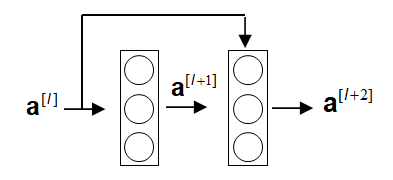

Figura 1 - Esquema de um bloco residual.

### Exercício #2: Codificação do bloco residual

Na célula abaixo crie uma função que implementa o bloco residual mostrado na Figura 1. Use a função de ativação relu.

In [ ]:
### PARA VOCÊ FAZER: Definir o bloco residual
# Importa classe de camadas e modelos
from tensorflow.keras import layers, models

# Importa função de ativação
from tensorflow.keras.activations import relu

def residual_block(x, units):
    # Primeira camada densa
    ### COMECE AQUI ### (1 linha)
    z1 = layers.Dense(units, activation='relu')(x)
    ### TERMINE AQUI ###

    # Segunda camada densa sem ativação
    ### COMECE AQUI ### (1 linha)
    z2 = layers.Dense(units)(z1)
    ### TERMINE AQUI ###

    # Soma entrada com z2 com saída da segunda camada
    ### COMECE AQUI ### (1 linha)
    a2 = layers.Add()([x, z2])
    ### TERMINE AQUI ###

    # Aplica função de ativação
    ### COMECE AQUI ### (1 linha)
    a2 = layers.Activation('relu')(a2)
    ### TERMINE AQUI ###

    return a2

Execute a célula abaixo para testar o seu bloco residual.

In [ ]:
np.random.seed(3)
x = np.random.randn(3,5)
a2 = residual_block(x, 5)
print('x:', x, '\n')
print('a2:', a2)

x: [[ 1.78862847  0.43650985  0.09649747 -1.8634927  -0.2773882 ]
 [-0.35475898 -0.08274148 -0.62700068 -0.04381817 -0.47721803]
 [-1.31386475  0.88462238  0.88131804  1.70957306  0.05003364]] 

a2: tf.Tensor(
[[2.6708326  2.578699   0.         0.         0.46271783]
 [0.         0.         0.         0.         0.        ]
 [0.         0.54442436 1.6318115  1.1220491  0.        ]], shape=(3, 5), dtype=float32)


**Saída esperada:**

    x: [[ 1.78862847  0.43650985  0.09649747 -1.8634927  -0.2773882 ]
    [-0.35475898 -0.08274148 -0.62700068 -0.04381817 -0.47721803]
    [-1.31386475  0.88462238  0.88131804  1.70957306  0.05003364]]

    a2: tf.Tensor(
    [[1.6887243  0.5611134  0.5987834  0.         0.67116445]
    [0.         0.03314844 0.         0.1769045  0.        ]
    [0.3389045  0.16169035 0.         0.7670167  0.        ]], shape=(3, 5), dtype=float32)

### Exercício #3: Configuração da rede

A rede que será utilizada será composta por 2 blocos residuais, sendo que entre eles deve ter um camada densa para ajustar a dimensão dos dados.

Na célula abaixo crie uma função para gerar a rede residual. Essa função deve receber o seguinte:

1. Dimensão das imagens de entrada;
2. lista com número de unidades em cada bloco e cada camada da rede;
3. Número de classes para definir o número de unidades da camada de saída;
4. Exceto na camada de saída utiliza função de ativação relu.

In [ ]:
### PARA VOCÊ FAZER: Definir a arquitetura do modelo

def create_residual_model(n1, n2, num_classes, input_shape=(2000,)):
    ### COMECE AQUI ###
    # Camada de entrada
    input_layer = layers.Input(shape=input_shape)
    # Primeira camada densa
    dense_1 = layers.Dense(n1, activation='relu')(input_layer)
    # Primeiro bloco residual
    residual_1 = residual_block(dense_1, n1)
    # Segunda camada densa
    dense_2 = layers.Dense(n2, activation='relu')(residual_1)
    # Segundo bloco residual
    residual_2 = residual_block(dense_2, n2)
    # Camada de saída
    output_layer = layers.Dense(num_classes, activation='softmax')(residual_2)
    # Construir o modelo
    model = models.Model(inputs=input_layer, outputs=output_layer)

    ### TERMINE AQUI ###

    return model


Para criar o modelo, utilize a função `create_residual_model()` com os seguintes parâmetros:

- n1 = 256;
- n2 = 128;
- num_classes = 10.


In [ ]:
# PARA VOCE FAZER: Criar modelo

# Definir parâmetros
### PARA VOCE FAZER ### (3 linhas)
n1 = 256
n2 = 128
num_classes = 4
### TERMINE AQUI ###

# Criar modelo
### PARA VOCE FAZER ### (1 linha)
rna = create_residual_model(n1, n2, num_classes)
### TERMINE AQUI ###

rna.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 2000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │        512,256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │         65,792 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 256)            │         65,792 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256)            │              0 │ dense_9[0][0],         │
│                           │                        │                │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256)            │              0 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 128)            │         32,896 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │         16,512 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 128)            │         16,512 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 128)            │              0 │ dense_12[0][0],        │
│                           │                        │                │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 128)            │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 4)              │            516 │ activation_4[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 710,276 (2.71 MB)

 Trainable params: 710,276 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

**Saída esperada:**

    Model: "functional"
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
    ┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
    ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
    │ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
    │ (InputLayer)              │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ flatten_1 (Flatten)       │ (None, 3072)           │              0 │ input_layer_1[0][0]    │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_12 (Dense)          │ (None, 256)            │        786,688 │ flatten_1[0][0]        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_13 (Dense)          │ (None, 256)            │         65,792 │ dense_12[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_14 (Dense)          │ (None, 256)            │         65,792 │ dense_13[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ add_6 (Add)               │ (None, 256)            │              0 │ dense_12[0][0],        │
    │                           │                        │                │ dense_14[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ activation_4 (Activation) │ (None, 256)            │              0 │ add_6[0][0]            │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_15 (Dense)          │ (None, 128)            │         32,896 │ activation_4[0][0]     │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_16 (Dense)          │ (None, 128)            │         16,512 │ dense_15[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_17 (Dense)          │ (None, 128)            │         16,512 │ dense_16[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ add_7 (Add)               │ (None, 128)            │              0 │ dense_15[0][0],        │
    │                           │                        │                │ dense_17[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ activation_5 (Activation) │ (None, 128)            │              0 │ add_7[0][0]            │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_18 (Dense)          │ (None, 10)             │          1,290 │ activation_5[0][0]     │
    └───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘
    Total params: 985,482 (3.76 MB)
    Trainable params: 985,482 (3.76 MB)
    Non-trainable params: 0 (0.00 B)

## 3. Compilação e treinamento do modelo

### Exercício #4: Compilação do modelo

Agora que o modelo foi criado, você precisa compilá-lo. Vamos usar a função de perda `categorical_crossentropy` para classificação multiclasse e o otimizador `Adam`.

In [ ]:
# PARA VOCE FAZER: Compilar o modelo

### COMECE AQUI ### (1 comando)
rna.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
### TERMINE AQUI ###

### Exercício #5: Treinar o modelo

Para treinar o modelo use 100 épocas e um lote de 256 exemplos.

In [ ]:
# PARA VOCE FAZER: Treinar o modelo

### COMECE AQUI ### (1 comando)
history = rna.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test))
### TERMINE AQUI ###

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2866 - loss: 1.3446 - val_accuracy: 0.2661 - val_loss: 1.3715
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3072 - loss: 1.3399 - val_accuracy: 0.2661 - val_loss: 1.3721
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3087 - loss: 1.3372 - val_accuracy: 0.2661 - val_loss: 1.3716
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2999 - loss: 1.3369 - val_accuracy: 0.2661 - val_loss: 1.3710
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3027 - loss: 1.3460 - val_accuracy: 0.2661 - val_loss: 1.3701
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2857 - loss: 1.3511 - val_accuracy: 0.2661 - val_loss: 1.3704
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3059 - loss: 1.3502 - val_accuracy: 0.2661 - val_loss: 1.3716
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3103 - loss: 1.3437 - val_accuracy: 0.2661 - 

**Saída esperada:**

    Epoch 1/100
    196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2288 - loss: 2.1627 - val_accuracy: 0.3783 - val_loss: 1.7425
    Epoch 2/100
    196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3720 - loss: 1.7419 - val_accuracy: 0.4168 - val_loss: 1.6358
    .
    .
    .
    Epoch 99/100
    196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9347 - loss: 0.1806 - val_accuracy: 0.4800 - val_loss: 4.0803
    Epoch 100/100
    196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9350 - loss: 0.1817 - val_accuracy: 0.4942 - val_loss: 4.1091

Execute a célula abaixo para vizualizar os gráficos do processo de treinamento.

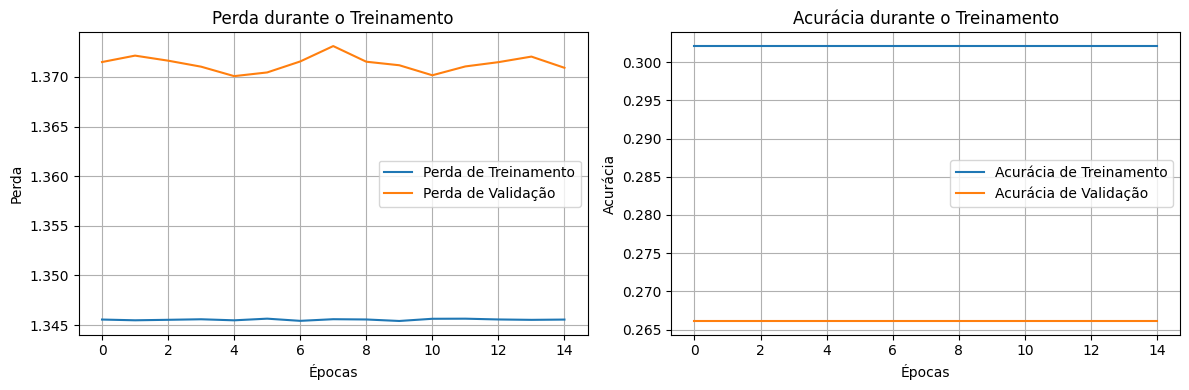

In [ ]:
# Plotar a perda e acurácia durante o treinamento
plt.figure(figsize=(12, 4))

# Plotando a perda
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid()
plt.legend()

# Plotando a acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### Exercício #6: Avaliar o modelo

Use o método evaluate e calcule a função de custo e a métrica para os dados de treinamento e teste.

In [ ]:
### PARA VOCE FAZER: Avaliar o modelo

### COMECE AQUI ### (2 linhas)

### TERMINE AQUI ###

**Saída esperada:**

    1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9438 - loss: 0.1639
    313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4957 - loss: 4.0715

## 4. Ajuste do modelo

Você agora tem um modelo básico de rede residual para classificação de imagens no conjunto CIFAR100. Por meio da adição de blocos residuais, o modelo pode ser mais profundo sem enfrentar problemas de degradação do desempenho.

Com base nesse modelo, você pode fazer experimentos adicionais para melhorar a performance, como ajustar a arquitetura, adicionar camadas de normalização, ou utilizar técnicas de data augmentation.

### Exercício #7: Ajustar o modelo para obter resultados melhores

Nesse exercício você deve fazer ajustes no modelo para melhorar o seu desempenho. As possíveis modificações são: adicionar mais blocos residuais, mudar o número de unidades nos blocos e nas camadas densas, ou tentar diferentes técnicas de regularização (dropout, L2 regularization etc.)  Além disso, é possível testar diferentes algoritmos de otimização e taxas de aprendizado.

Implemente as seguintes modificações no modelo:

1. Aumentar número de blocos residuais e aumentar número de unidades nas camadas;
2. Incluir camadas de dropout no modelo maior do item (1);
3. Retirar as camadas de dropout e aplicar regularização L2 no modelo maior do item(1).

Para cada modificação você deve apresentar o novo modelo, a compilação, o treinamento e a avaliação.

A sua avaliação nesse exercício depende dos resultados de exatidão nos dados de teste.

Analise os resultados do ajuste do modelo.